# Librerie


In [26]:
import os, hexdump

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

import sklearn as sk

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Caricamento e descrizione del dataset

Il [modello](https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook) utilizzato riguarda il numero di prodotti venduti di un determinato negozio.


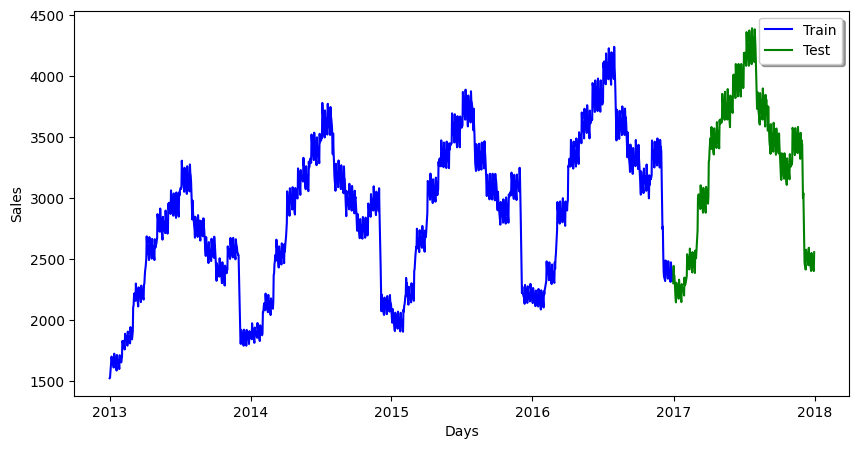

In [2]:
all_data = pd.read_csv('dataset/train.csv', parse_dates=['date'])
all_data = all_data.sort_values('date').groupby(['store', 'date'], as_index=False)['sales'].sum()
all_data = all_data[ all_data['store'] == 10 ]

all_data = all_data.set_index('date')
all_data = all_data.rolling('6d').mean()
all_data = all_data.reset_index()

all_date = pd.DataFrame( {'date': all_data['date']} )     # mi salvo la lista di date
all_data = pd.DataFrame( {'sales': all_data['sales']} )   # seleziono solo la colonna 'sales'

scaler = MinMaxScaler(feature_range=(0,1))
all_data_scaled = pd.DataFrame( {'sales': scaler.fit_transform(all_data.values).ravel() })  # ravel per fare unroll

dataset_size = all_data.shape[0]
train_size = int ( (dataset_size/100) * 80 )
test_size = dataset_size-train_size

train_date = all_date.head(train_size)
test_date = all_date.tail(test_size)

train = all_data.head(train_size)
test = all_data.tail(test_size)

#train_scaled = all_data_scaled.head(train_size)
#test_scaled = all_data_scaled.tail(test_size)

plt.figure(figsize=(10, 5))

plt.plot(train_date['date'], train['sales'], color='b', label="Train")
plt.plot(test_date['date'], test['sales'], color='g', label="Test")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend(loc='best', shadow=True)

In [3]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Conversione a problema supervisionato e reshape per LSTM

In [4]:
WINDOW = 4
NUM_PREVISION = 1

to_sup = series_to_supervised(all_data_scaled[['sales']], window=WINDOW, lag=NUM_PREVISION)
tmp_Y = to_sup["sales(t+1)"]
tmp_X = to_sup.drop("sales(t+1)", axis=1)

X_train = tmp_X.head(train_size)
Y_train = tmp_Y.head(train_size)

X_test = tmp_X.tail(test_size)
Y_test = tmp_Y.tail(test_size)

# reshape
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))      # se non faccio scaling usa 'X_test.values.reshape....'

print('Train LSTM Shape', X_train.shape)
print("Train LSTM Label Shape: ",Y_train.shape)
print("\n")
print('Test LSTM Shape', X_test.shape)
print("Test Label Shape: ",Y_test.shape)

Train LSTM Shape (1460, 5, 1)
Train LSTM Label Shape:  (1460,)


Test LSTM Shape (366, 5, 1)
Test Label Shape:  (366,)


# Creazione NN

Si tratta di un problema di previsione di serie temporali e quindi è stata implementata una rete [LSTM (Long Short Term Memory) ](https://www.mlq.ai/time-series-tensorflow-lstm-rnn/) in modo da riuscire a fare inferenza su valori futuri tenendo conto di un certo numero di osservazioni passate (5 in questo caso).

Sono state implementate 3 reti LSTM in ordine di complessita.

Viene usata tanh come funziona di attivazione.

[Link](https://github.com/google-coral/edgetpu/issues/323) che descrive l'errore che si ottiene quando si fa la quantizzazione.

In [5]:
models = {
    "small": Sequential([
        LSTM(units=10, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(units=1)
    ]),
    "medium": Sequential([
        LSTM(units=15, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(units=1)
    ]),
    "large": Sequential([
        LSTM(units=15, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        LSTM(units=10),
        Dense(units=1)
    ]),
}

In [6]:
BATCH_SIZE = 4

models_history = {}
for name, model in models.items():
    model.compile(loss=tf.losses.MeanSquaredError(), 
                  optimizer=tf.keras.optimizers.Adam())
    models_history[name] = model.fit(X_train, Y_train, validation_split=0.2, epochs=20, batch_size=BATCH_SIZE)

Epoch 1/20
292/292 [==============================] - 6s 8ms/step - loss: 0.0100 - val_loss: 0.0020
Epoch 2/20
292/292 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 3/20
292/292 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 4/20
292/292 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/20
292/292 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 6/20
292/292 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 7/20
292/292 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 8/20
292/292 [==============================] - 2s 6ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/20
292/292 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/20
292/292 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 0.0023

# Valutazione NN

In [88]:
def mape_fn(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test)) *100
    return mape

for name, model in models.items():
    print(name+" :")
    y_pred = model.predict(X_test, verbose=0)

    y_pred_not_scaled = scaler.inverse_transform(y_pred)
    Y_test_not_scaled = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))
    
    mae = metrics.mean_absolute_error(Y_test_not_scaled, y_pred_not_scaled)
    mape = metrics.mean_absolute_percentage_error(Y_test_not_scaled, y_pred_not_scaled)
    print("MAE: "+str(mae))
    print("MAPE: "+str(mape))
    print("MAPE_percent: "+str(mape_fn(Y_test_not_scaled, y_pred_not_scaled)))

    print("\n")

small :
MAE: 90.89800614042576
MAPE: 0.028597658681056414
MAPE_percent: 2.8597658681056415


medium :
MAE: 72.30885078694217
MAPE: 0.022303964804842348
MAPE_percent: 2.230396480484235


large :
MAE: 95.24607818547929
MAPE: 0.028532663806874956
MAPE_percent: 2.8532663806874954




12/12 [==============================] - 0s 6ms/step


Text(0, 0.5, 'Sales')

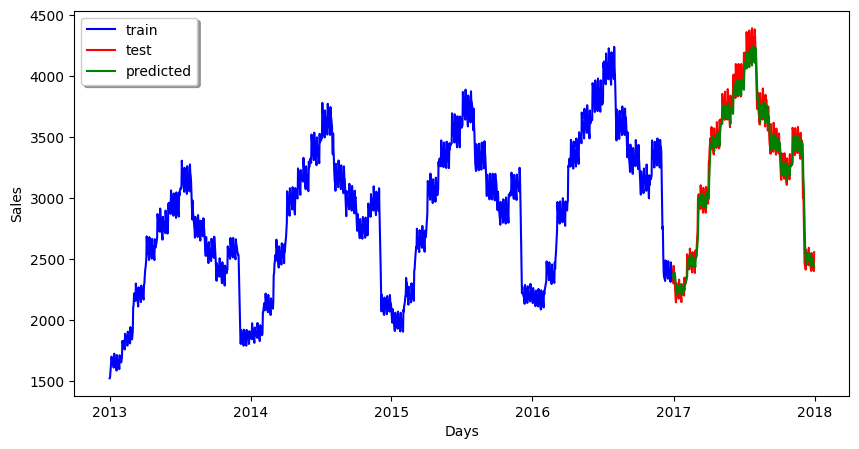

In [80]:
y_pred = models['medium'].predict(X_test)

y_pred_not_scaled = scaler.inverse_transform(y_pred)

plt.figure(figsize=(10, 5))

plt.plot(train_date['date'], train['sales'], color='b', label="train")
plt.plot(test_date['date'], test['sales'], color='r', label="test")
plt.plot(test_date['date'], y_pred_not_scaled, color='g', label="predicted")
plt.legend(loc='best', shadow=True)

plt.xlabel('Days')
plt.ylabel('Sales')

# Conversione modello in header C

La conversione è stata fatta seguendo le indicazioni presenti nella [guida ufficiale](https://www.tensorflow.org/lite/models/convert/rnn?hl=it) e il [relativo esempio](https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/examples/experimental_new_converter/Keras_LSTM_fusion_Codelab.ipynb?hl=it#scrollTo=0-b0IKK2FGuO).  

Oltre alla normale conversione, per il modello 'large' è stata fatta anche una full-integer quantization. E' stato quindi opportuno capire le performance del modello quantizzato andandolo ad eseguire tramite l'apposito interprete per poi conforntare le performance con il modello non quantizzato.

Di seguito è riportato il codice per la creazione dell'header c nel quale ho inserito anche l'input che verrà usato come test sulla scheda per simulare la predizione di un sample reale. L'input in questo caso è rappresentatao dal sample di test con id 'id_sample_to_test'. Il risultato della predizione che si ottiene sulle schede deve essere uguale a quello che si ottiene in questo notebook.

In [85]:
"""
Converto il modello Tensorflow in un modello Tensoflow Lite.
E' possibile utilizzare la full-integer-quantization per ridurre la dimensione
del modello e diminuire il tempo di inferenza.

Per poterla usare, è necessario definire un dataset rappresentativo per poter definire
il range.

Link utile per creazione dataset rappresentativo : https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Custom_Image_Classification_EdgeTPU.ipynb

Params: 
  - model: modello Tensorflow da convertire
  - model_dir: directory dentro la quale salvare il modello per il fissaggio degli input
  - batch_size: grandezza del batch utilizzata
  - input_shape: forma dell'input
  - full_int_quantization: bool per decidere se usare quantizzazione o no
  - x_train: dataset di train usato per la creazione del dataset rappresentativo nel caso si voglia
             fare quantizzazione

Return: modello Tensorflow Lite
"""
def convert_to_tflite(tfmodel, model_dir, batch_size, input_shape, full_int_quantization=False, x_train=None):

    run_model = tf.function(lambda x: tfmodel(x))

    # fisso la dimensione degli input
    concrete_func = run_model.get_concrete_function(
        tf.TensorSpec([batch_size, input_shape[1], input_shape[2]], tfmodel.inputs[0].dtype))

    # salvo modello
    tfmodel.save(model_dir, save_format="tf", signatures=concrete_func)

    # converto modello in tf-lite 
    converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)

    if (full_int_quantization):

      x_train_tflite = x_train.astype('float32')  

      def representative_dataset():
        for input_value in tf.data.Dataset.from_tensor_slices(x_train_tflite).batch(batch_size).take(1450):
          # Model has only one input so each data point has one element.
          yield [input_value]

      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.representative_dataset = representative_dataset
      converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
      converter.inference_input_type = tf.int8
      converter.inference_output_type = tf.int8    
    else:
      converter.optimizations = []
      
    return converter.convert()


"""
Funzione per il salvataggio di un modello Tensorflow Lite come header C che verrà
importato nel sorgente C del microcontrollore.

E' possibile inserire anche la variabile da utilizzare come input per poter testare
la correttezza della previsione del modello.
E' possibile inserire anche la dimensione degli input/output.

Params:
  - file_name: nome del file in cui salvare l'header C
  - tflite_model: modello Tensorflow Lite
  - variable_name: nome della variabile che contiene i byte del modello
  - variables_to_append: stringhe aggiuntive inserite in coda che contengono ad
      esempio il valore dell'input da testare 
"""
def save_c_header(file_name, tflite_model, variable_name="model_data", variables_to_append=""):

  bytes = hexdump.dump(tflite_model).split(' ')
  c_array = ', '.join(['0x%02x' % int(byte, 16) for byte in bytes])
  c = 'const unsigned char %s[] DATA_ALIGN_ATTRIBUTE = {%s};' % (variable_name, c_array)
  c += '\nconst int %s_len = %d;' % (variable_name, len(bytes))
  preamble = '''
    // if having troubles with min/max, uncomment the following
    // #undef min    
    // #undef max
    #ifdef __has_attribute
    #define HAVE_ATTRIBUTE(x) __has_attribute(x)
    #else
    #define HAVE_ATTRIBUTE(x) 0
    #endif
    #if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
    #define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
    #else
    #define DATA_ALIGN_ATTRIBUTE
    #endif
    '''
  open(file_name+".h", "w").write(preamble + c + variables_to_append)

"""
Avviene la valutazione delle performance di un genercico modello Tensorflow Lite.

E' necessario eseguire il modello Tensorflow Lite tramite il relativo interprete
e poi valutare il risultato delle previsioni.

E' richiesto che i float siano a 32 bit.

Params:
  - x_test: x di test su cui valutare il modello
  - y_test: y true di test per la valutazione del modello
  - tflite_model: modello Tensorflow Lite da valutare
  - io_quantized: True se tensori di input o output hanno bisogno di essere quantizzati/dequantizzati
  - id_sample_to_test: id del sample nel train set da valutare

Return: dizionario con i risultati della valutazione
"""
def tflite_model_evaluate(x_test, y_test, tflite_model, io_quantized=False, id_sample_to_test=0):

  x_test_tflite = x_test.astype('float32')

  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # quantizzo input per full-integer se serve
  if (io_quantized):
    input_scale, input_zero_point = input_details[0]["quantization"]
    x_test_tflite = x_test_tflite / input_scale + input_zero_point
    x_test_tflite = x_test_tflite.astype(input_details[0]["dtype"])

  y_pred = []

  for i in range(len(x_test_tflite)-4):
      
    interpreter.set_tensor(input_details[0]["index"], x_test_tflite[i:i+4])
    interpreter.invoke()
    #y_pred.append(0 if (interpreter.get_tensor(output_details[0]["index"])[0][0] < 0.5) else 1)
    y_pred.append(interpreter.get_tensor(output_details[0]["index"])[0][0])
    interpreter.reset_all_variables()

  # de-quantizzo output per full-integer se serve 
  if (io_quantized):
    y_pred = np.array(y_pred, dtype='float32')
    output_scale, output_zero_point = output_details[0]["quantization"]
    y_pred = (y_pred - output_zero_point) * output_scale

  y_pred_not_scaled = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
  Y_test_not_scaled = scaler.inverse_transform(np.array(y_test[:-4]).reshape(-1, 1))
    
  mae = metrics.mean_absolute_error(Y_test_not_scaled, y_pred_not_scaled)
  mape = metrics.mean_absolute_percentage_error(Y_test_not_scaled, y_pred_not_scaled) 
  mape_percent = mape_fn(Y_test_not_scaled, y_pred_not_scaled)
  
  return {"Prediction value of test sample with ID "+str(id_sample_to_test): y_pred[id_sample_to_test], 
          "mae": mae, "mape": mape, "mape_percent": mape_percent} 

"""
Funzione per printare il risultato della valutazione
"""
def print_evaluation(title, eval_dict):

  print(title)
  for k,v in eval_dict.items():
    print(k+": "+str(v))  

In [86]:
n_input = WINDOW+1

# inserisco il sample del test set con un certo id
id_sample_to_test = 5
sample_input = "\nfloat x["+str(n_input)+"] = {"
for i in range(0, n_input):
  sample_input = sample_input + str( X_test[id_sample_to_test:id_sample_to_test+1][0][i][0] )
  if ( not(i == n_input-1) ):         # mette la virgola a tutti tranne che l'ultimo
    sample_input = sample_input + ", "
sample_input += "};\n"
sample_input = sample_input + "const int input_size = "+str(n_input)+";\n"
sample_input = sample_input + "const int output_size = 1;"

for name, model in models.items():
  file_name = "c_headers/TimeSeriesLSTMmodel_"+name
  model_dir = "models/LSTM_"+name
  tflite_model = convert_to_tflite(model, model_dir, BATCH_SIZE, X_train.shape)
  save_c_header(file_name, tflite_model, variables_to_append=sample_input)

  if (name.endswith("large")):
    file_name = "c_headers/TimeSeriesLSTMmodel_"+name+"_quant"
    tflite_model_quant = convert_to_tflite(model, model_dir, BATCH_SIZE, X_train.shape, full_int_quantization=True, x_train=X_train)
    save_c_header(file_name, tflite_model_quant, variables_to_append=sample_input)  
    print_evaluation("TF model "+name+"_quant : ", tflite_model_evaluate(X_test, Y_test, 
                                                                         tflite_model_quant, 
                                                                         id_sample_to_test=id_sample_to_test, 
                                                                         io_quantized=True,))    

INFO:tensorflow:Assets written to: models/LSTM_small/assets


INFO:tensorflow:Assets written to: models/LSTM_small/assets
2023-05-31 14:57:55.737252: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-31 14:57:55.737275: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-31 14:57:55.737641: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: models/LSTM_small
2023-05-31 14:57:55.750976: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-05-31 14:57:55.751000: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: models/LSTM_small
2023-05-31 14:57:55.786707: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-05-31 14:57:55.916291: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: models/LSTM_small
2023-05-31 14:57:55.997521: I tensorflow/cc/saved_model/loader.cc:316] Saved

INFO:tensorflow:Assets written to: models/LSTM_medium/assets


INFO:tensorflow:Assets written to: models/LSTM_medium/assets
2023-05-31 14:58:02.495559: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-31 14:58:02.495622: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-31 14:58:02.495907: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: models/LSTM_medium
2023-05-31 14:58:02.510767: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-05-31 14:58:02.510792: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: models/LSTM_medium
2023-05-31 14:58:02.548675: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-05-31 14:58:02.672602: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: models/LSTM_medium
2023-05-31 14:58:02.754406: I tensorflow/cc/saved_model/loader.cc:316] S

INFO:tensorflow:Assets written to: models/LSTM_large/assets


INFO:tensorflow:Assets written to: models/LSTM_large/assets
2023-05-31 14:58:14.889656: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-31 14:58:14.889705: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-31 14:58:14.889990: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: models/LSTM_large
2023-05-31 14:58:14.912038: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-05-31 14:58:14.912064: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: models/LSTM_large
2023-05-31 14:58:14.978489: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-05-31 14:58:15.184877: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: models/LSTM_large
2023-05-31 14:58:15.341264: I tensorflow/cc/saved_model/loader.cc:316] Saved

INFO:tensorflow:Assets written to: models/LSTM_large/assets


INFO:tensorflow:Assets written to: models/LSTM_large/assets
2023-05-31 14:58:27.840092: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-31 14:58:27.840127: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-31 14:58:27.840399: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: models/LSTM_large
2023-05-31 14:58:27.867367: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-05-31 14:58:27.867392: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: models/LSTM_large
2023-05-31 14:58:27.932990: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-05-31 14:58:28.135190: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: models/LSTM_large
2023-05-31 14:58:28.281992: I tensorflow/cc/saved_model/loader.cc:316] Saved

TF model large_quant : 
Prediction value of test sample with ID 5: 0.27298537
mae: 193.88334675432355
mape: 0.051933202241681777
mape_percent: 5.193320224168177


Controllo il valore delle predizioni

In [87]:
for name, model in models.items():
    print(name+" :")
    print(model.predict(X_test[id_sample_to_test:id_sample_to_test+1], verbose=0))

small :
[[0.3043552]]
medium :
[[0.2896354]]
large :
[[0.26698044]]
